In [1]:
from pytorch_tools import CreateDataset, train_model_cls, train_model_reg, plot_metrics
from train_models import ClassifierTrainer

/Users/aleksejkitajskij/Desktop/DS-Lifehacks/pytorch/pytorch_tools.py:19: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/opt/anaconda3/envs/goit/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## binary classification

In [2]:
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/Module_1_Lecture_2_Class_Spaceship_Titanic.csv')
df = df.set_index('PassengerId')

TARGET = 'Transported'
FEATURES = [col for col in df.columns if col != TARGET]

imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService"]
imputer = SimpleImputer(strategy='median')
imputer.fit(df[imputer_cols])
df[imputer_cols] = imputer.transform(df[imputer_cols])

df["HomePlanet"].fillna('Gallifrey', inplace=True)
df["Destination"].fillna('Skaro', inplace=True)

df['CryoSleep_is_missing'] = df['CryoSleep'].isna().astype(int)
df['VIP_is_missing'] = df['VIP'].isna().astype(int)

df["CryoSleep"].fillna(False, inplace=True)
df["VIP"].fillna(False, inplace=True)

df["CryoSleep"] = df["CryoSleep"].astype(int)
df["VIP"] = df["VIP"].astype(int)

dummies = pd.get_dummies(df.loc[:, ['HomePlanet', 'Destination']], dtype=int)

df = pd.concat([df, dummies], axis=1)
df.drop(columns=['HomePlanet', 'Destination'], inplace=True)

df[TARGET] = df[TARGET].astype(int)

df.drop(["Name" ,"Cabin"] , axis=1 ,inplace = True)

In [4]:
X = df.drop(TARGET , axis =1 ).values
y = df[TARGET].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.33, stratify = y)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [5]:
train_dataset = CreateDataset(X_train, y_train, scaler='StandardScaler')
test_dataset = CreateDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset,
                              batch_size=len(X_train),
                              num_workers=0
                             )

test_dataloader = DataLoader(test_dataset,
                              batch_size=len(X_test),
                              num_workers=0
                             )

In [6]:
class Net(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

In [7]:
input_dim = X_train.shape[1]
model = Net(input_dim)
parameters = list(model.parameters())

criterion = nn.BCELoss()
optimizer = optim.SGD(parameters, lr=0.01)

In [8]:
parameters

[Parameter containing:
 tensor([[-0.2073,  0.2045,  0.2139, -0.0351, -0.1548, -0.0562,  0.2295, -0.0097,
           0.0097,  0.1339,  0.2258, -0.1591,  0.1595,  0.2173,  0.0862,  0.2204,
           0.1861, -0.0705]], requires_grad=True),
 Parameter containing:
 tensor([0.0525], requires_grad=True)]

In [9]:
trainer = ClassifierTrainer(model=model,
                            criterion=criterion,
                            optimizer=optimizer,
                            num_classes=2,
                            device='cpu')

trainer.fit(train_dataloader,
            test_dataloader,
            num_epoch=100,
            info_every_iter=5,
            show_val_metrics=False)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/100] Train Loss: 0.8449 Acc: 0.3446 Rec: 0.3757 Prec: 0.3569
Epoch [10/100] Train Loss: 0.8355 Acc: 0.3575 Rec: 0.3771 Prec: 0.3661
Epoch [15/100] Train Loss: 0.8263 Acc: 0.3664 Rec: 0.3761 Prec: 0.3723
Epoch [20/100] Train Loss: 0.8174 Acc: 0.3743 Rec: 0.3737 Prec: 0.3775
Epoch [25/100] Train Loss: 0.8088 Acc: 0.3848 Rec: 0.3761 Prec: 0.3862
Epoch [30/100] Train Loss: 0.8004 Acc: 0.3944 Rec: 0.3829 Prec: 0.3954
Epoch [35/100] Train Loss: 0.7923 Acc: 0.4004 Rec: 0.3849 Prec: 0.4008
Epoch [40/100] Train Loss: 0.7843 Acc: 0.4075 Rec: 0.3877 Prec: 0.4072
Epoch [45/100] Train Loss: 0.7767 Acc: 0.4186 Rec: 0.3938 Prec: 0.4180
Epoch [50/100] Train Loss: 0.7692 Acc: 0.4294 Rec: 0.4023 Prec: 0.4291
Epoch [55/100] Train Loss: 0.7619 Acc: 0.4392 Rec: 0.4091 Prec: 0.4391
Epoch [60/100] Train Loss: 0.7549 Acc: 0.4497 Rec: 0.4200 Prec: 0.4503
Epoch [65/100] Train Loss: 0.7481 Acc: 0.4636 Rec: 0.4364 Prec: 0.4653
Epoch [70/100] Train Loss: 0.7415 Acc: 0.4770 Rec: 0.4514 Prec: 0.4795
Epoch [

In [10]:
metrics, model = train_model_cls(
    num_classes=2,
    num_epoch=100,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    info_every_iter=5
)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/100] Train Loss: 0.7003 Acc: 0.5587 Rec: 0.5390 Prec: 0.5648
Epoch [10/100] Train Loss: 0.6950 Acc: 0.5642 Rec: 0.5445 Prec: 0.5706
Epoch [15/100] Train Loss: 0.6900 Acc: 0.5695 Rec: 0.5479 Prec: 0.5764
Epoch [20/100] Train Loss: 0.6851 Acc: 0.5742 Rec: 0.5486 Prec: 0.5819
Epoch [25/100] Train Loss: 0.6803 Acc: 0.5809 Rec: 0.5544 Prec: 0.5891
Epoch [30/100] Train Loss: 0.6757 Acc: 0.5859 Rec: 0.5632 Prec: 0.5936
Epoch [35/100] Train Loss: 0.6712 Acc: 0.5893 Rec: 0.5660 Prec: 0.5973
Epoch [40/100] Train Loss: 0.6668 Acc: 0.5972 Rec: 0.5782 Prec: 0.6046
Epoch [45/100] Train Loss: 0.6626 Acc: 0.6032 Rec: 0.5881 Prec: 0.6100
Epoch [50/100] Train Loss: 0.6584 Acc: 0.6095 Rec: 0.6031 Prec: 0.6144
Epoch [55/100] Train Loss: 0.6544 Acc: 0.6219 Rec: 0.6253 Prec: 0.6244
Epoch [60/100] Train Loss: 0.6506 Acc: 0.6338 Rec: 0.6458 Prec: 0.6339
Epoch [65/100] Train Loss: 0.6468 Acc: 0.6430 Rec: 0.6655 Prec: 0.6400
Epoch [70/100] Train Loss: 0.6431 Acc: 0.6530 Rec: 0.6846 Prec: 0.6469
Epoch [

In [11]:
with torch.no_grad():
    y_pred = model(X_test).squeeze().numpy().round()

accuracy_score(y_test, y_pred)

0.7371906587661206

In [12]:
parameters

[Parameter containing:
 tensor([[ 0.2170,  0.0717,  0.1139, -0.2277, -0.0471, -0.0413, -0.0073, -0.1617,
           0.0071,  0.0798,  0.0495,  0.0793,  0.1124,  0.2007,  0.1535,  0.1336,
           0.1154, -0.0521]], requires_grad=True),
 Parameter containing:
 tensor([0.0392], requires_grad=True)]

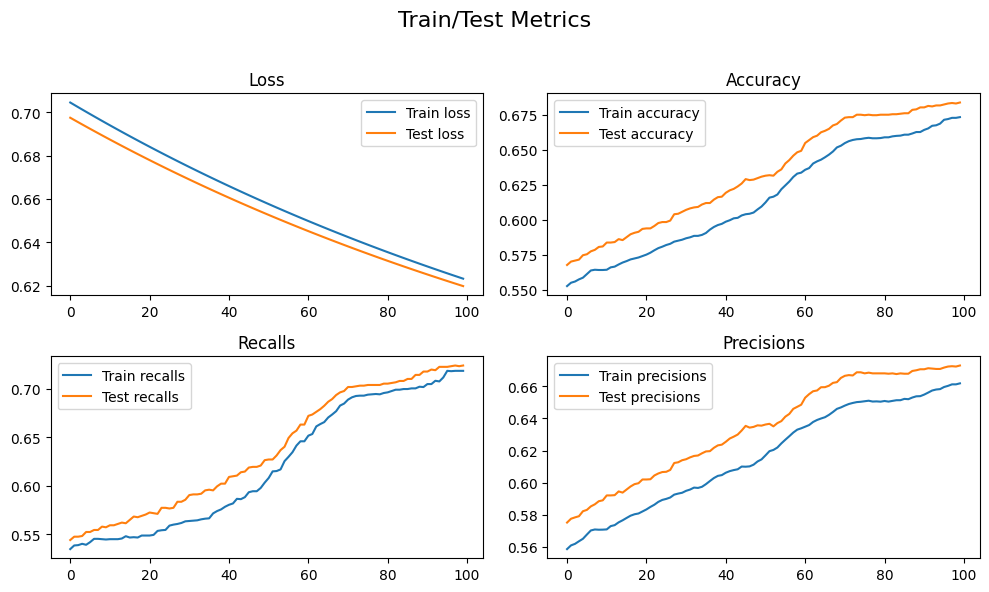

In [13]:
plot_metrics(metrics)

## multyclass classification

In [14]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [15]:
df = pd.read_csv('data/Module_2_Lecture_2_Class_penguins.csv')
df = df.dropna().reset_index(drop=True)
features = ['species', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
df = df.loc[:, features]
df.loc[df['species']=='Adelie', 'species']=0
df.loc[df['species']=='Gentoo', 'species']=1
df.loc[df['species']=='Chinstrap', 'species']=2
df = df.apply(pd.to_numeric)

In [16]:
X = df.drop('species', axis =1).values
y = df['species'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size =0.33, stratify=y)

X_train = torch.Tensor(X_train).float()
y_train = torch.Tensor(y_train).long()
X_test = torch.Tensor(X_test).float()
y_test = torch.Tensor(y_test).long()

In [17]:
train_dataset = CreateDataset(X_train, y_train, scaler='StandardScaler')
test_dataset = CreateDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset,
                              batch_size=20,
                              num_workers=0
                             )

test_dataloader = DataLoader(test_dataset,
                              batch_size=20,
                              num_workers=0
                             )

In [18]:
train_dataset.scaler

StandardScaler()

In [19]:
num_classes = len(np.unique(y_train))
num_classes

3

In [20]:
class Net(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim=20, out_dim=3):
        super().__init__()
        
        self.features = torch.nn.Sequential(
            
            nn.Linear(in_dim, hidden_dim),
            torch.nn.ReLU(),
            
            nn.Linear(hidden_dim, out_dim),
            nn.Softmax()
        )    
        
    def forward(self, x):
        output = self.features(x)
        return output

In [21]:
model = Net(X_train.shape[1], 20, num_classes)
parameters = list(model.parameters())

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(parameters, lr=0.01)

In [22]:
metrics, model = train_model_cls(
    num_classes=num_classes,
    num_epoch=100,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    model=model,
    criterion=criterion,
    optimizer=optimizer
)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100] Train Loss: 1.0835 Acc: 0.3219 Rec: 0.3219 Prec: 0.1702
Epoch [2/100] Train Loss: 1.0676 Acc: 0.3726 Rec: 0.3726 Prec: 0.2458
Epoch [3/100] Train Loss: 1.0518 Acc: 0.4320 Rec: 0.4320 Prec: 0.3142
Epoch [4/100] Train Loss: 1.0362 Acc: 0.5340 Rec: 0.5340 Prec: 0.4132
Epoch [5/100] Train Loss: 1.0209 Acc: 0.6156 Rec: 0.6156 Prec: 0.4968
Epoch [6/100] Train Loss: 1.0059 Acc: 0.6429 Rec: 0.6429 Prec: 0.5296
Epoch [7/100] Train Loss: 0.9913 Acc: 0.6565 Rec: 0.6565 Prec: 0.5475
Epoch [8/100] Train Loss: 0.9773 Acc: 0.6633 Rec: 0.6633 Prec: 0.5569
Epoch [9/100] Train Loss: 0.9638 Acc: 0.6667 Rec: 0.6667 Prec: 0.5618
Epoch [10/100] Train Loss: 0.9509 Acc: 0.6667 Rec: 0.6667 Prec: 0.5618
Epoch [11/100] Train Loss: 0.9386 Acc: 0.6667 Rec: 0.6667 Prec: 0.5618
Epoch [12/100] Train Loss: 0.9269 Acc: 0.6667 Rec: 0.6667 Prec: 0.5618
Epoch [13/100] Train Loss: 0.9159 Acc: 0.6667 Rec: 0.6667 Prec: 0.5618
Epoch [14/100] Train Loss: 0.9054 Acc: 0.6667 Rec: 0.6667 Prec: 0.5618
Epoch [15/100] 

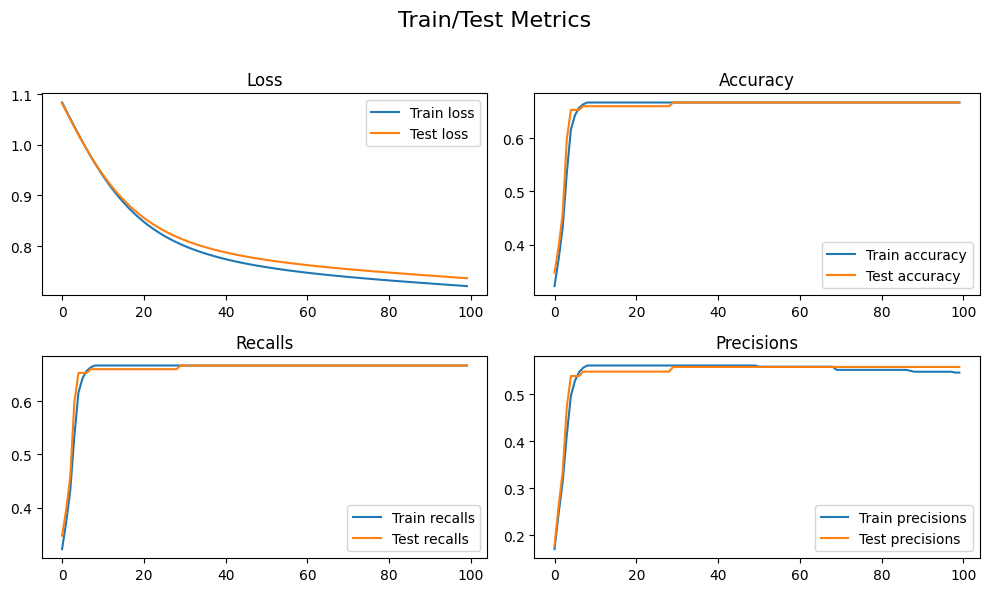

In [23]:
plot_metrics(metrics)

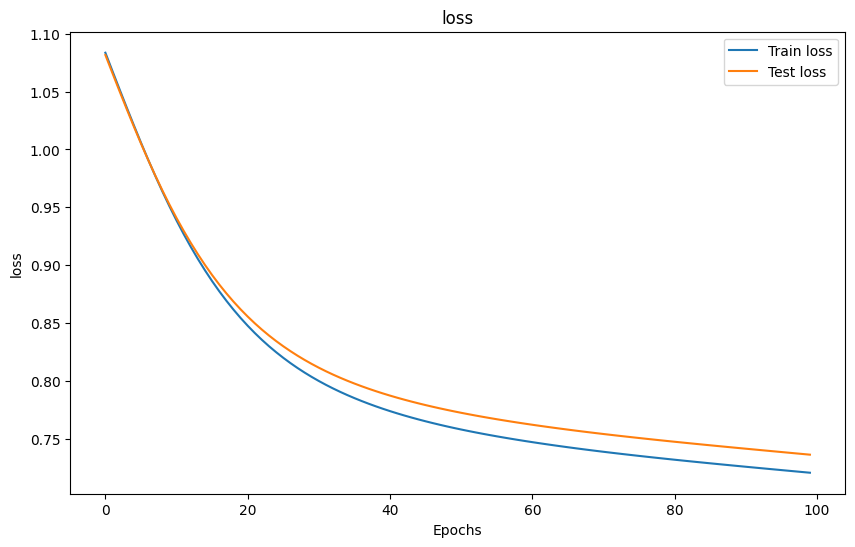

In [24]:
plot_metrics(metrics, 'loss')

## regression

In [25]:
from dataclasses import dataclass

import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [26]:
data_path = 'data/Module_2_Lecture_2_Class_bigmart_data.csv'
data = pd.read_csv(data_path)
data['Outlet_Establishment_Year'] = 2013 - data['Outlet_Establishment_Year']
data['Item_Visibility'] = (data['Item_Visibility']
                           .mask(data['Item_Visibility'].eq(0), np.nan))

data['Item_Visibility_Avg'] = (data
                               .groupby(['Item_Type',
                                         'Outlet_Type'])['Item_Visibility']
                               .transform('mean'))

data['Item_Visibility'] = (
    data['Item_Visibility'].fillna(data['Item_Visibility_Avg']))

data['Item_Visibility_Ratio'] = (
    data['Item_Visibility'] / data['Item_Visibility_Avg'])

data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({
    'low fat': 'Low Fat',
    'LF': 'Low Fat',
    'reg': 'Regular'})

data['Item_Identifier_Type'] = data['Item_Identifier'].str[:2]
data_num = data.select_dtypes(include=np.number)
data_cat = data.select_dtypes(include='object')

In [27]:
X_train_num, X_test_num, X_train_cat,  X_test_cat, y_train, y_test = (
    train_test_split(
        data_num.drop(['Item_Outlet_Sales',
                       'Item_Visibility_Avg'], axis=1).values,
        data_cat.drop('Item_Identifier', axis=1).values,
        data['Item_Outlet_Sales'].values,
        test_size=0.2,
        random_state=42))

num_imputer = SimpleImputer().set_output(transform='pandas')
X_train_num = num_imputer.fit_transform(X_train_num)
X_test_num = num_imputer.transform(X_test_num)

cat_imputer = SimpleImputer(strategy='most_frequent').set_output(transform='pandas')
X_train_cat = cat_imputer.fit_transform(X_train_cat)
X_test_cat = cat_imputer.transform(X_test_cat)
enc_auto = TargetEncoder(random_state=42).set_output(transform='pandas')
X_train_cat = enc_auto.fit_transform(X_train_cat, y_train)
X_test_cat = enc_auto.transform(X_test_cat)

X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test = pd.concat([X_test_num, X_test_cat], axis=1)

In [28]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6818, 12), (1705, 12), (6818,), (1705,))

In [29]:
train_dataset = CreateDataset(X_train, y_train)
test_dataset = CreateDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset,
                              batch_size=20,
                              num_workers=0
                             )

test_dataloader = DataLoader(test_dataset,
                              batch_size=20,
                              num_workers=0
                             )

In [30]:
class LinearModel(torch.nn.Module):
    def __init__(self, in_dim, out_dim=1):
        super().__init__()
        
        self.features = torch.nn.Sequential(
            nn.Linear(in_dim, 256),
            torch.nn.ReLU(),
            
            nn.Linear(256, 128),
            torch.nn.ReLU(),
            
            nn.Linear(128, 64),
            torch.nn.ReLU(),
            
            nn.Linear(64, out_dim),
        )
    
        
    def forward(self, x):
        output = self.features(x)
        return output

In [31]:
model = LinearModel(in_dim=X_train.shape[1], out_dim=1)
  
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [32]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print("Використовується пристрій:", device)

Використовується пристрій: mps


In [33]:
metrics, model = train_model_reg(num_epoch=20,
                    train_dataloader = train_dataloader,
                    test_dataloader = test_dataloader,
                    model=model,
                    criterion=criterion,
                    optimizer=optimizer,
                    device=device,
                    show_val_metrics=True,
                    info_every_iter=2
                    )

  0%|          | 0/20 [00:00<?, ?it/s]

AttributeError: 'NoneType' object has no attribute 'early_stop'

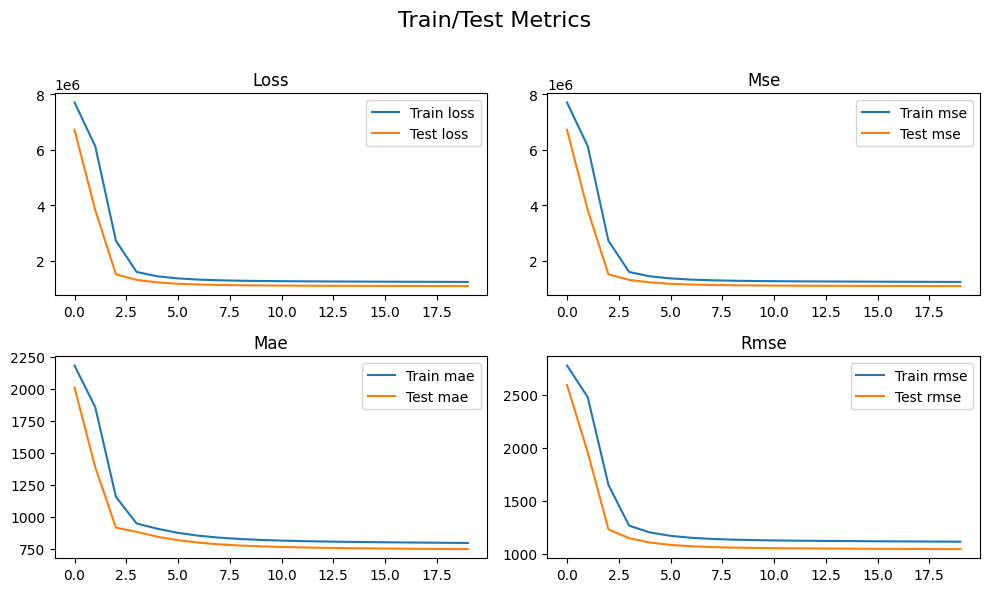

In [ ]:
plot_metrics(metrics)